In [47]:
%matplotlib inline
from scipy.stats import poisson, uniform, expon
from IPython.core.pylabtools import figsize
import numpy as np
import pymc as pm

import matplotlib.pyplot as plt
import matplotlib as mpl

(array([  3.,   2.,   6.,   9.,  15.,  17.,  15.,  19.,  12.,  16.,  15.,
         31.,  32.,  40.,  31.,  24.,  10.,   2.,   0.,   1.]),
 array([  47.40688607,   58.916721  ,   70.42655594,   81.93639088,
          93.44622581,  104.95606075,  116.46589569,  127.97573062,
         139.48556556,  150.99540049,  162.50523543,  174.01507037,
         185.5249053 ,  197.03474024,  208.54457518,  220.05441011,
         231.56424505,  243.07407999,  254.58391492,  266.09374986,
         277.60358479]),
 <a list of 1 Patch objects>)

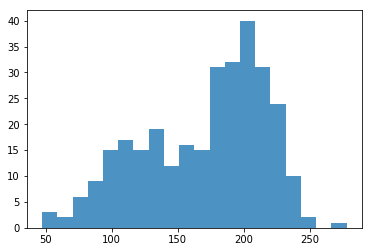

In [8]:
data = np.loadtxt("data/mixture_data.csv", delimiter=",")
plt.hist(data, bins=20, histtype="stepfilled", alpha=0.8)

各ポアソン分布の$\lambda$の事前分布

$p(\lambda_k)={\rm Gam} (\lambda_k|a,b)$

In [29]:
K = 2 # クラスタ数
lambda_ = pm.Gamma("lambda_", alpha=1, beta=1, size=K)
lambda_.value

array([ 0.80892073,  0.30522467])

所属確率$\pi$の事前分布

$p(\pi_k)={\rm Dir}(\pi_k|\alpha)$

In [37]:
pi = pm.Dirichlet("pi", theta=[1,1])
pi.value

array([ 0.83926351])

潜在変数$s$の事前分布

$p(s_n|\pi)={\rm Cat}(s_n|\pi)$

In [17]:
p = pm.Uniform("p", 0., 1.)
s = pm.Categorical("s", [p, 1 - p], size=data.shape[0])  # 潜在変数はデータ数分

In [39]:
@pm.deterministic
def lambda_i(s=s, lambda_=lambda_):
    return lambda_[s]  # k個あるポアソン分布のうち、一つだけがsによって指定される

In [40]:
# 観測データ（あるポアソン分布から観測データは生成される）
obs = pm.Poisson("obs", lambda_i, value=data, observed=True)

In [41]:
# --------  モデリング-------------------#
model = pm.Model([p, s, lambda_])
mcmc = pm.MCMC(model)
mcmc.sample(50000)

 [-----------------100%-----------------] 50000 of 50000 complete in 11.8 sec

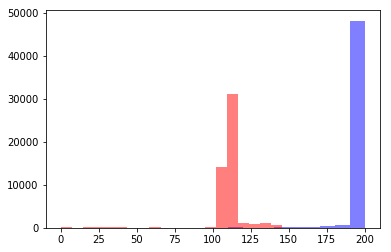

In [54]:
colors = ["blue", "red"]

lambda_samples = mcmc.trace('lambda_')[:]

# クラスタの平均の分布
for i in range(2):
    plt.hist(lambda_samples[:, i], color=colors[i], alpha=0.5, bins=20)

(35, 300)

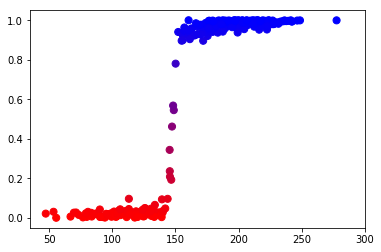

In [55]:
s_samples = mcmc.trace('s')[:]
# 値ごとのクラスタ所属確率
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
plt.scatter(data, 1 - s_samples.mean(axis=0), cmap=cmap,
        c=s_samples.mean(axis=0), s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)